[Indice](index.ipynb) | Previo: [Problema3Cuerpos.Aplicaciones.OrbitasCRTBP](08.06.02.00.Problema3Cuerpos.Aplicaciones.OrbitasCRTBP.ipynb) | Siguiente: [Problema3Cuerpos.ProblemasSeleccionados](08.06.00.00.Problema3Cuerpos.ProblemasSeleccionados.ipynb)

### 8.13.9. El parámetro de Tisserand
<a id='trescuerpos_parametro_tisserand'></a>

En la mayor parte de este capítulo hemos estudiado la dinámica de sistemas restringidos de tres cuerpos (aquellos donde al menos uno tiene una masa muy pequeña) en un marco de referencia rotante en el que los cuerpos más masivos están casi en reposo (o totalmente en reposo como sucede en el CRTBP).  Usar marcos de referencia rotantes nos ha permitido aprender cosas increíbles sobre estos sistemas que de otra manera parecerían intratables teóricamente o por lo menos tratables solo con métodos numéricos.  Sin embargo, trabajar por demasiado tiempo en este tipo de marcos de referencia, puede hacernos perder de vista la curiosa apariencia que tiene la dinámica de sistemas de tres cuerpos en el marco de referencia inercial del centro de masa.

Para ilustrar este efecto, consideremos por ejemplo el siguiente sistema de partículas:

In [1]:
sistema=[
    #Partícula de prueba
    dict(
        m=1e-5,
        r=[6.0,0,-0.1],
        v=[0,2.0,0.1]
    ),
    # Particula 1
    dict(
        m=1000.0,
        r=[-0.005,0,0],
        v=[0,-7.075,0]
    ),
    # Particula 2
    dict(
        m=1.0,
        r=[4.995,0,0],
        v=[0,+7.075,0]
    ),
]

Resolvamos las ecuaciones de movimiento y grafiquemos la trayectoria respecto al centro de masa:

In [2]:
%matplotlib nbagg

<a id='code:T_sistema_ejemplo'></a>

<IPython.core.display.Javascript object>


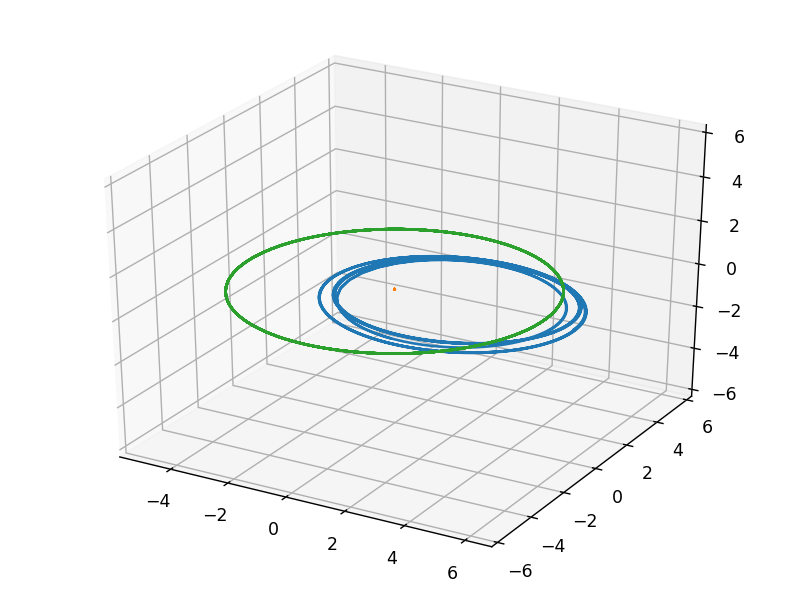

In [3]:
T=20.0
Nt=1000
from numpy import linspace
ts=linspace(0,T,Nt)
from pymcel.export import ncuerpos_solucion
rs,vs,rps,vps,constantes=ncuerpos_solucion(sistema,ts)
from pymcel.export import plot_ncuerpos_3d
fig=plot_ncuerpos_3d(rps,vps);
ax=fig.gca()
#ax.view_init(90,90)

<a id='code:T_sistema_ejemplo'></a><center><b>Figura 8.136.</b> </center>

En este punto, no hay mucho de que sorprenderse en la Figura ([code:T_sistema_ejemplo](#fig:code:T_sistema_ejemplo)): vemos a la partícula de prueba en una trayectoria ovalada alrededor del cuerpo central (muy cerca al origen de coordenadas) y perturbada notoriamente por la presencia de lo que podríamos llamar el *planeta*; este último se mueve a su vez en una trayectoria aproximadamente circular alrededor del cuerpo central.  Situaciones como la representada aquí se encuentran frecuentemente en el sistema solar.  El planeta podría ser Júpiter y la partícula de prueba un cometa con una órbita excéntrica y perturbado por su presencia.  O podría ser la Tierra y la partícula un asteroide que cruza su órbita.  

Consideremos ahora la siguiente pregunta: un observador que detectara el cometa o el asteroide en momentos muy diferentes del tiempo y que observara solo un pequeño tramo de su trayectoria ¿podría reconocer que se trata del mismo cuerpo?. Normalmente, el proceso de determinar si dos cuerpos pequeños, observados en momentos diferentes, corresponden al mismo cuerpo, es comparar los elementos de la órbita oculatriz en los dos momentos de observación.  

Calculemos los elementos orbitales principales ($a$, $e$, $i$) de la partícula de prueba con respecto a la partícula central y veamos cómo cambian en el tiempo:

<a id='code:T_sistema_ejemplo_elementos'></a>

<IPython.core.display.Javascript object>


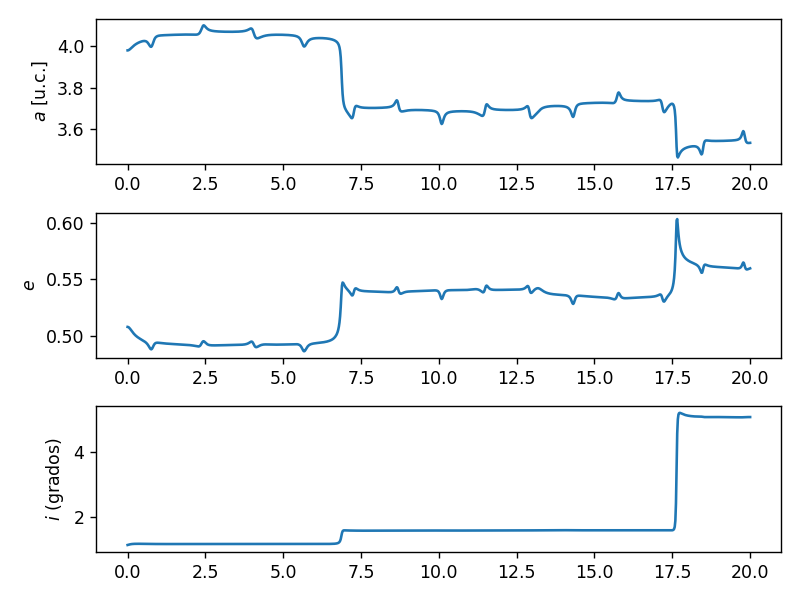

In [4]:
#Parámetro gravitacional del sistema
mu=sistema[1]["m"]+sistema[2]["m"]

#Cálculo 
elts=[]
for i in range(Nt):
    #Vector de estado en el tiempo i-esimo
    from numpy import concatenate
    state=concatenate((rps[0,i,:],vps[0,i,:]))
    #Convierte el vector de estado a elementos orbitales
    from spiceypy import oscltx
    elementos=oscltx(state,0,mu)
    from numpy import pi
    elts+=[[elementos[9],elementos[1],elementos[2]]]
from numpy import array
elts=array(elts)
    
#Gráfico
import matplotlib.pyplot as plt
fig,axs=plt.subplots(3,1)
axs[0].plot(ts,elts[:,0])
axs[0].set_ylabel('$a$ [u.c.]')
axs[1].plot(ts,elts[:,1])
axs[1].set_ylabel('$e$')
axs[2].plot(ts,elts[:,2]*180/pi)
axs[2].set_ylabel('$i$ (grados)')
fig.tight_layout()

<a id='code:T_sistema_ejemplo_elementos'></a><center><b>Figura 8.137.</b> </center>

Como puede verse, en la figura Figura ([code:T_sistema_ejemplo_elementos](#fig:code:T_sistema_ejemplo_elementos)), entre el inicio de la integración y $t\approx 7.5$ los elementos orbitales ($a,e,I$) de la partícula de prueba producen valores más o menos consistentes.  Cualquier observación que se realice en ese intervalo mostrará que se trata del mismo cuerpo.  Sin embargo a partir de ese momento los elementos orbitales dan un salto; este cambio repentino es producto de las perturbaciones gravitacionales que produce el planeta.  Un observador que determinara los elementos del cuerpo en por ejemplo $t=10$ encontraría un objeto con un semiejemayor más pequeño y una excentricidad e inclinación mayores.  Naturalmente, el observador no sabe que se trata del mismo objeto y fácilmente podría pensar que se trata de uno nuevo.

Veámos ahora qué ocurre si nos pasamos a un marco de referencia rotante que tenga exactamente la misma velocidad angular del planeta alrededor del cuerpo central.  Para ello podemos usar procedimientos similares a los que usamos en la [Sección *Cuadratura de Jacobi de un sistema real*](08.02.00.00.Problema3Cuerpos.ConstanteJacobi.ipynb#constante_jacobi_real):

<IPython.core.display.Javascript object>


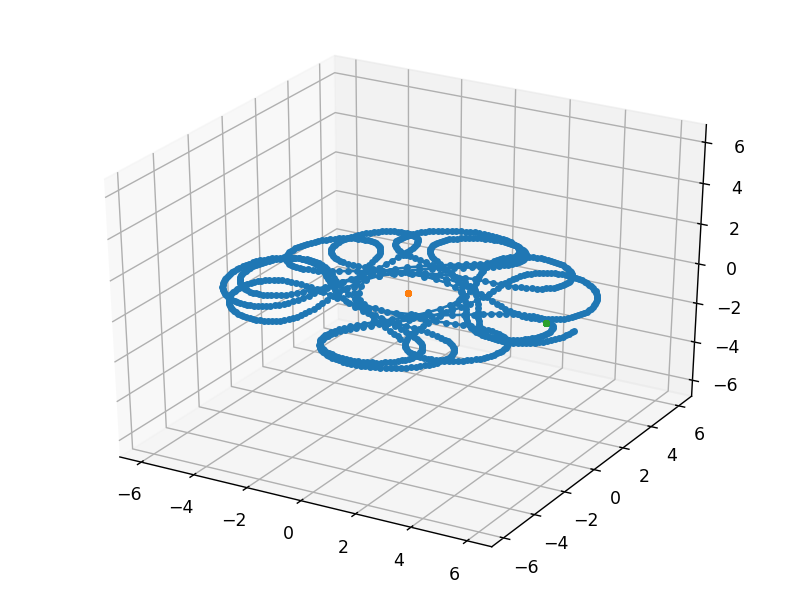

In [5]:
#Distancia entre las partículas 1 y 2
from numpy.linalg import norm
r12=norm(rps[1]-rps[2],axis=1)

#Promedio
a_P=r12.mean()

#Velocidad angular del planet
from numpy import sqrt
m1=sistema[1]["m"]
m2=sistema[2]["m"]
n=sqrt((m1+m2)/a_P**3)

#Velocidad angular
w=n
from numpy import array
omega=array([0,0,w])

#Vectores en el sistema rotado
from numpy import zeros_like
rps_rot=zeros_like(rps)
vps_rot=zeros_like(vps)
for i in range(Nt):

    #Matriz de rotación
    from spiceypy import rotate,mxv
    R=rotate(w*ts[i],3)

    #Rota las posiciones y velocidades de cada partícula
    for n in range(3):
        rps_rot[n,i]=mxv(R,rps[n,i])
        #v' = v + w x r
        from spiceypy import vcrss
        vps_rot[n,i]=mxv(R,vps[n,i]-vcrss(omega,rps[n,i]))
        
from pymcel.export import plot_ncuerpos_3d
fig=plot_ncuerpos_3d(rps_rot,vps_rot,marker='o',ms=3);

<a id='fig:08.06.03.00.Problema3Cuerpos.Aplicaciones.ParametroTisserand_138'></a><center><b>Figura 8.138.</b> </center>

En el marco de referencia rotante, la partícula de prueba esta lejos de describir una trayectoria arbitraria.  Esto era de esperarse: dado que el planeta tiene una órbita casi circular vemos que las condiciones básicas del CRTBP se cumplen en el sistema y podemos aplicar lo que hemos aprendido para analizar el problema.  Comencemos por ejemplo calculando la constante de Jacobi asociada con el movimiento de la partícula: 

<a id='code:T_CJ_numerico'></a>

<IPython.core.display.Javascript object>


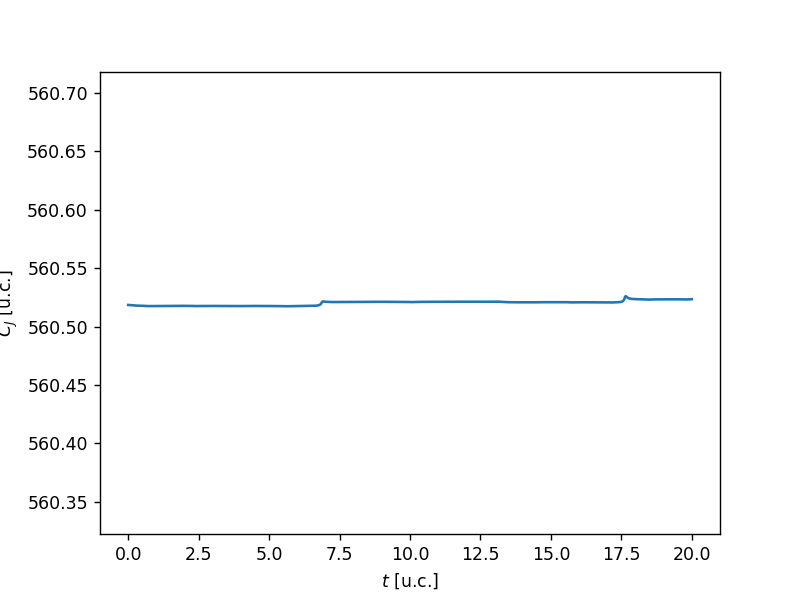

In [6]:
#Posiciones de la partícula de prueba
r=rps_rot[0]

#Posiciones y velocidades relativas a las partículas masivas
from numpy.linalg import norm
r1=norm(rps_rot[0]-rps_rot[1],axis=1)
r2=norm(rps_rot[0]-rps_rot[2],axis=1)

#Rapideces
v=norm(vps_rot[0],axis=1)

#Parametros gravitacionales
mu1=m1
mu2=m2

#Cuadratura de Jacobi
CJ=2*mu1/r1+2*mu2/r2+w**2*(r[:,0]**2+r[:,1]**2)-v**2

#Grafico
fig=plt.figure()
ax=fig.gca()
ax.plot(ts,CJ)
ax.set_xlabel("$t$ [u.c.]");
ax.set_ylabel("$C_J$ [u.c.]");
ax.set_ylim((CJ.mean()-100*CJ.std(),CJ.mean()+100*CJ.std()));


<a id='code:T_CJ_numerico'></a><center><b>Figura 8.139.</b> Valor de la constante de Jacobi para el sistema real de tres cuerpos simulado en el capítulo.</center>

Y de nuevo confirmamos lo que habíamos aprendido hasta ahora: la constante de Jacobi del sistema es aproximadamente constante.  Nótese que la constancia de $C_J$ está en contraste directo con la variabilidad de los elementos orbitales. Lo mejor que un observador puede hacer entonces para evaluar si dos cuerpos pequeños que observa en fechas muy distintas, son en realidad el mismo cuerpo, es calcular la constante de Jacobi (en relación con el cuerpo perturbador) en las dos fechas.  Si el valor es igual el cuerpo es con seguridad el mismo.

Suena fácil al decirlo, pero el procedimiento mostrado en los algorítmos anteriores demuestra que calcular la constante de Jacobi no es sencillo. ¿Existe una manera de calcular esta constante usando solamente los elementos orbitales clásico calculados en distintas observaciones?. Ese fue precisamente el útil resultado que obtuvo el astrónomo francés Francois Félix Tisserand ("franzua felix [tisserra](https://forvo.com/search/Tisserand/fr/)") hacia el final de los 1800.

La constante de Jacobi esta escrita en términos de las variables de estado del sistema rotante que habíamos acostumbrado escribir primadas:

\begin{equation}
\label{eq:T_CJ}
C_J=\frac{2(1-\alpha)}{r'_{1}} + \frac{2\alpha}{r'_{2}} + (x'^2 + y'^2)-v'^2
\end{equation}

Si queremos escribir la constante en términos de los elementos orbitales (que son cantidades definidas en el sistema de referencia inercial) tenemos que convertir primero las cantidades primadas que aparecen en la ecuación anterior, en las cantidades no primadas del sistema de referencia inercial.

Si definimos la matriz de rotación como:

$$
R(t)=\left(\begin{array}{ccc}
\cos t & \sin t & 0\\
-\sin t & \cos t & 0\\  
0 & 0 & 1
\end{array}\right)
$$
las componentes del vector posición y la velocidad se relacionan por:

\begin{equation}
\label{eq:T_rp_r}
\vec r'=R\vec r
\end{equation}
y

\begin{equation}
\label{eq:T_vp_v}
\vec v'= R(\vec v-\hat e_z\times\vec r)
\end{equation}

Dejemos a un lado los primeros dos términos de la ecuación de la constante (ya nos ocuparemos de ellos enseguida).  Veamos ahora en qué se convierte el término $x'^2+y'^2$ al aplicar la regla de transformación en la Ec. ([T_rp_r](#mjx-eqn-eq%3AT_rp_r)):

$$
x'^2 + y'^2  = (x \cos t + y \sin t)^2+(- x \sin t + y \cos t)^2 = x^2 + y^2
$$

Es fácil mostrar de aquí que también $|\vec r'|=|\vec r|$.

Este mismo resultado puede aplicarse para obtener el término $v'^2$ usando la Ec. ([T_vp_v](#mjx-eqn-eq%3AT_vp_v)):

$$
v'^2=(\vec v-\hat e_z\times\vec r)\cdot(\vec v-\hat e_z\times\vec r)=v^2-2\vec v\cdot(\hat e_z\times \vec r)+(\hat e_z\times \vec r)^2
$$

Aplicando la propiedad cíclica del triple producto vectorial podemos escribir: 

$$
\vec v\cdot(\hat e_z\times \vec r)=\hat e_z\cdot(\vec r\times \vec v)=h_z
$$
donde $h_z$ es la componente vertical del *momento angular relativo específico* de la partícula de prueba con respecto al centro de masa del sistema.  Podemos escribir esta cantidad en términos de los elementos orbitales de la órbita osculatriz, usando las relaciones que obtuvimos en el [Capítulo *El problema de los dos cuerpos*](07.00.00.00.Problema2Cuerpos.ipynb#problema_doscuerpos):

$$
h_z=h\cos i=\sqrt{a(1-e^2)}\cos i
$$

Por otro lado $\hat e_z\times\vec r=x \hat e_y-y\hat e_x$ de donde:

$$
(\hat e_z\times \vec r)^2=x^2+y^2
$$

Con estas cantidades el cuadrado de la magnitud de la velocidad en el sistema rotante se puede escribir finalmente como:

$$
v'^2=v^2-2\cos i\sqrt{a(1-e^2)}+x^2+y^2
$$

Reemplazando las relaciones anteriores en la fórmula de la constante de Jacobi (Ec. [T_CJ](#mjx-eqn-eq%3AT_CJ)) obtenemos:

$$
C_J=\frac{2(1-\alpha)}{r'_{1}} + \frac{2\alpha}{r'_{2}}-v^2+2\cos i\sqrt{a(1-e^2)}
$$

Ahora bien, el cuadrado de la rapidez en el sistema inercial se puede escribir usando la *vis-viva*:

$$
v^2=\frac{2}{r}-\frac{1}{a}
$$
donde $r$ es la distancia de la partícula de prueba al centro de masa.  De aquí:

\begin{equation}
\label{eq:T_CJ_inercial}
C_J=2\left(\frac{1}{r'_1}-\frac{1}{r}\right)+2\alpha\left(\frac{1}{r'_2}-\frac{1}{r'_1}\right)+\frac{1}{a}+2\cos i\sqrt{a(1-e^2)}
\end{equation}

En la mayoría de los sistemas de interés en el Sistema Solar $\alpha\ll 1$ (por ejemplo en el sistema Sol-Tierra $\alpha\sim 10^{-6}$, mientras que en el sistema Sol-Júpiter $\alpha\sim 10^{-4}$).  En estas condiciones la distancia de la partícula de prueba a la partícula central $r_1'$ y al centro de masa $r$ serán casi idénticas.  De este modo el primer término de la ecuación anterior se puede considerar despreciable.  Por otro lado, el segundo término, que es proporcional a $\alpha$ es, en la mayoría de las posiciones relevantes de la partícula de prueba (es decir cuando $r'_1,r'_2\sim 1$) ciertamente mucho menor que 1.  Los términos restantes son, sin embargo de orden 1 e incluso mayores.  

Con todo, una buena aproximación a la constante de Jacobi en un sistema de dos cuerpos se puede escribir como:

\begin{equation}
\label{eq:T_uc}
C_J\approx T\equiv \frac{1}{a}+2\cos i\sqrt{a(1-e^2)}
\end{equation}

A la cantidad $T$ se la conoce como el **parámetro de Tisserand**.

Es muy importante entender, que en toda la deducción que hicimos en los párrafos anteriores, usamos las unidades canónicas del problema de los dos cuerpos, es decir, aquellas en las que $\mu=G(m_1+m_2)=1$ y $a_p=1$.  Solo en este sistema de unidades el parámetro de Tisserand tiene la forma de la Ec. ([T_uc](#mjx-eqn-eq%3AT_uc)).

Si queremos poner a prueba el resultado anterior con el sistema que estudiamos al principio de esta sección, es necesario primero convertir los valores de las cantidades calculadas anteriormente al sistema de unidades del problema del CRTBP.  Para ello primero hay que definir y calcular los factores de conversión respectivos:

In [7]:
UM=m1+m2
UL=a_P
from numpy import sqrt
UT=sqrt(UL**3/UM)
UV=UL/UT

In [8]:
print(f"U_M = {UM}")
print(f"U_L = {UL}")
print(f"U_T = {UT}")
print(f"U_V = {UV}")

U_M = 1001.0
U_L = 5.000563774746299
U_T = 0.35343651552050726
U_V = 14.148407295669351


Nótese que en las unidades del sistema original ya habíamos hecho $G=1$, de modo que al calcular aquí el factor de conversión de la unidad de tiempo usamos precisamente es valor.

Para convertir los valores de la constante de Jacobi, que obtuvimos antes con el algoritmo [T_uc](#mjx-eqn-eq%3AT_uc)([T_CJ_numerico](#code:T_CJ_numerico)), al nuevos sistema de unidades, debemos recordar que $C_J$ tiene unidades de velocidad al cuadrado:

In [9]:
CJ_uc=CJ/UV**2

In [10]:
from numpy import set_printoptions
set_printoptions(threshold=11,precision=3,suppress=True)
print(f"CJ (unidades canónicas) = {CJ_uc}")

CJ (unidades canónicas) = [2.8 2.8 2.8 ... 2.8 2.8 2.8]


Por otro lado, para calcular el valor del parámetro de Tisserand, necesitamos también convertir, a las unidades canónicas del CRTBP, el valor de los elementos orbitales calculados en [T_uc](#mjx-eqn-eq%3AT_uc)([T_CJ_numerico](#code:T_CJ_numerico))([T_sistema_ejemplo_elementos](#code:T_sistema_ejemplo_elementos)):

In [11]:
a_uc=elts[:,0]/UL
e_uc=elts[:,1]
i_uc=elts[:,2]

In [12]:
from numpy import set_printoptions
set_printoptions(threshold=11,precision=3,suppress=True)
print(f"a (unidades canónicas) = {a_uc}")

a (unidades canónicas) = [0.796 0.796 0.796 ... 0.707 0.707 0.707]


Naturalmente al ser la excentricidad y la inclinación cantidades adimensionales no requieren ninguna conversión.

Con estos cambios, el parámetro de Tisserand para este sistema será:

In [13]:
from numpy import sqrt,cos
T=1/a_uc+2*cos(i_uc)*sqrt(a_uc*(1-e_uc**2))

In [14]:
from numpy import set_printoptions
set_printoptions(threshold=11,precision=3,suppress=True)
print(f"T (unidades canónicas) = {T}")

T (unidades canónicas) = [2.793 2.793 2.794 ... 2.803 2.803 2.803]


El valor de $T$ coincide aproximadamente con el de $C_J$ como era de esperarse.  Una comparación más justa puede hacerse si graficamos ambas cantidades:

<IPython.core.display.Javascript object>


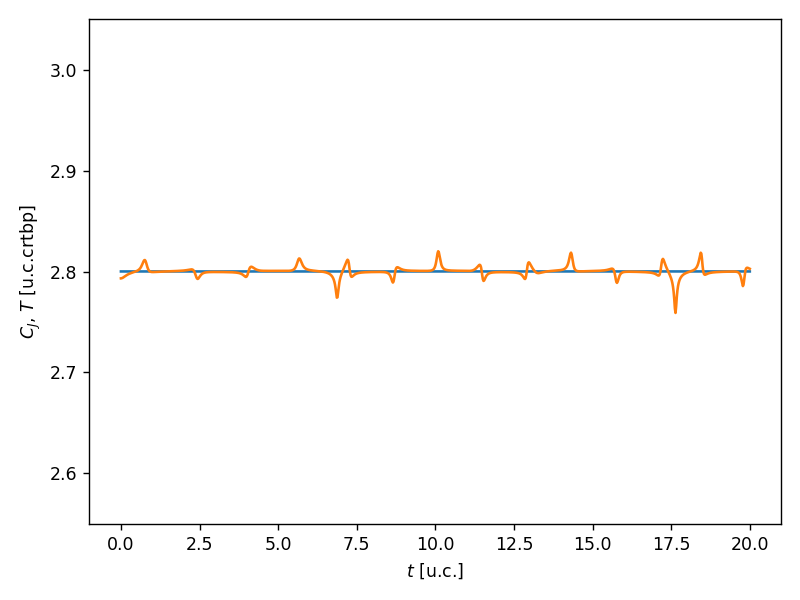

In [15]:
fig=plt.figure()
ax=fig.gca()
ax.plot(ts,CJ_uc)
ax.plot(ts,T)
ax.set_xlabel("$t$ [u.c.]");
ax.set_ylabel("$C_J$, $T$ [u.c.crtbp]");
ax.set_ylim((T.mean()-50*T.std(),
             T.mean()+50*T.std()));
fig.tight_layout()

<a id='fig:08.06.03.00.Problema3Cuerpos.Aplicaciones.ParametroTisserand_140'></a><center><b>Figura 8.140.</b> </center>

Como vemos, la coincidencia no es perfecta durante todo el movimiento. Ambas cantidades difieren significativamente, especialmente, cuando la partícula de prueba esta muy cerca al planeta y el término $2\alpha/r'_2$ en la Ec. ([T_CJ_inercial](#mjx-eqn-eq%3AT_CJ_inercial)) ya no puede considerarse despreciable. 

Incluso con estas discrepancias, es claro que si un observador, en lugar de (solo) comparar los elementos orbitales de dos cuerpos observados en distintos momentos de la historia, compara el valor del parámetro de Tisserand, tendrá una mayor posibilidad de determinar si se trata del mismo o de cuerpos diferentes.

### 8.13.1. Clasificación de los objetos cercanos a la Tierra
<a id='T_NEOs_clasificacion'></a>

En el sistema solar, el parámetro de Tisserand ha sido usado históricamente para clasificar los cuerpos pequeños que son perturbados por algunos planetas importantes. El caso más relevante es el de los asteroides y cometas conocidos como **NEOs**, del acrónimo en inglés *Near Earth Objects* (objetos cercanos a la Tierra).  Un cuerpo pequeño del sistema solar es un **NEO** si, por convención, su distancia al sol en el perihelio es menor o igual a 1.3 unidades astronómicas.

En el algoritmo a continuación se lee una tabla de las propiedades orbitales básicas de los NEOs conocidos, obtenida de las [bases de datos de NASA de objetos pequeños del sistema solar](https://ssd.jpl.nasa.gov/sbdb_query.cgi):

In [16]:
from pandas import read_csv
datos=read_csv("pymcel/data/NEOs-2020_02.csv",index_col=["full_name"])

In [17]:
datos.head(3)

,q,e,i,w,om
full_name,,,,,
433 Eros (1898 DQ),1.132973,0.222951,10.830543,178.882294,304.299327
719 Albert (1911 MT),1.196452,0.546558,11.567485,156.176338,183.866950
887 Alinda (1918 DB),1.062886,0.570332,9.393854,350.495585,110.434218


Podemos calcular el parámetro de Tisserand de estos asteroides respecto de la Tierra usando la Ec. ([T_uc](#mjx-eqn-eq%3AT_uc)) sin necesidad de cambiar las unidades de los elementos órbitales.  La razón es sencilla: el único elemento orbital en la tabla anterior que tiene unidades es $q$ y estas son justamente unidades astronómicas, que es el valor de $a_P$ en el CRTBP en este caso.  

En el algoritmo a continuación calculamos el valor de $T$ para todos los NEOs:

In [18]:
datos["a"]=datos["q"]/(1-datos["e"])
from numpy import cos,sqrt,pi
datos["T"]=1/datos["a"]+2*cos(datos["i"]*pi/180)*\
           sqrt(datos["a"]*(1-datos["e"]**2))

In [19]:
datos[["a","e","i","T"]].head(3)

,a,e,i,T
full_name,,,,
433 Eros (1898 DQ),1.458046,0.222951,10.830543,2.998120
719 Albert (1911 MT),2.638602,0.546558,11.567485,3.044307
887 Alinda (1918 DB),2.473737,0.570332,9.393854,2.953457


Un gráfico de dispersión de los datos, se puede hacer con el siguiente algoritmo:

<a id='code:NEOs_dispersion'></a>

<IPython.core.display.Javascript object>


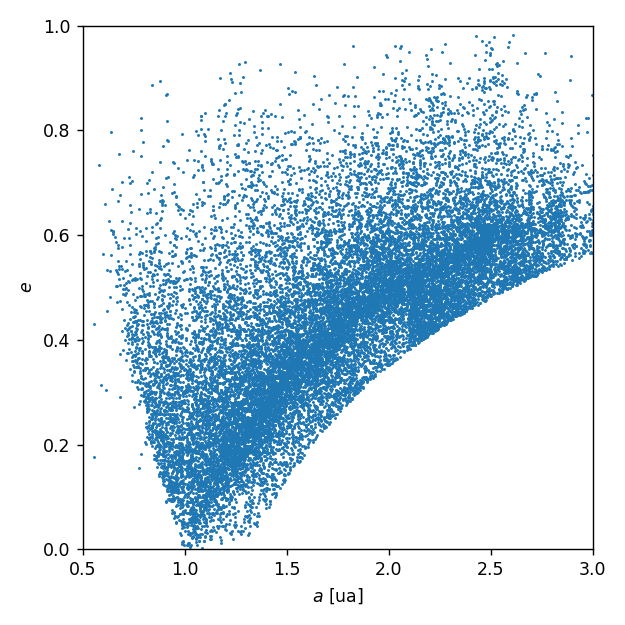

In [20]:
fig=plt.figure(figsize=(5,5))
ax=fig.gca()
s=ax.scatter(datos["a"],datos["e"],s=0.5)
ax.set_xlim((0.5,3.0))
ax.set_ylim((0.0,1.0))
ax.set_xlabel("$a$ [ua]")
ax.set_ylabel("$e$")
fig.tight_layout()

<a id='code:NEOs_dispersion'></a><center><b>Figura 8.141.</b> </center>

El marcado límite a la derecha en la Figura ([code:NEOs_dispersion](#fig:code:NEOs_dispersion)), corresponde simplemente a la definición misma de NEO, es decir $q\le1.3$, que se puede expresar matemáticamente como:

$$
e\ge 1-\frac{1.3}{a}
$$

En el mismo gráfico podemos ver como se concentra un número significativo de cuerpos en una franja aproximadamente paralela al borde de la distribución.  Para entender esta concentración, podemos despejar la excentricidad a partir de la fórmula para el parámetro de Tisserand en la Ec. ([T_uc](#mjx-eqn-eq%3AT_uc)):

$$
e=\sqrt{1-\frac{1}{4a^3\cos^2 i}(Ta-1)^2}
$$

Dada un semieje mayor $a$, los cuerpos con una excentricidad igual a la obtenida con la fórmula anterior tendrán el mismo valor del parámetro de Tisserand.  Con el algortimo a continuación podemos repetir el gráfico de dispersión de los NEOs, incluyendo las curvas definidas por las fórmulas anteriores

<a id='code:NEOs_dispersion_limites'></a>

<IPython.core.display.Javascript object>


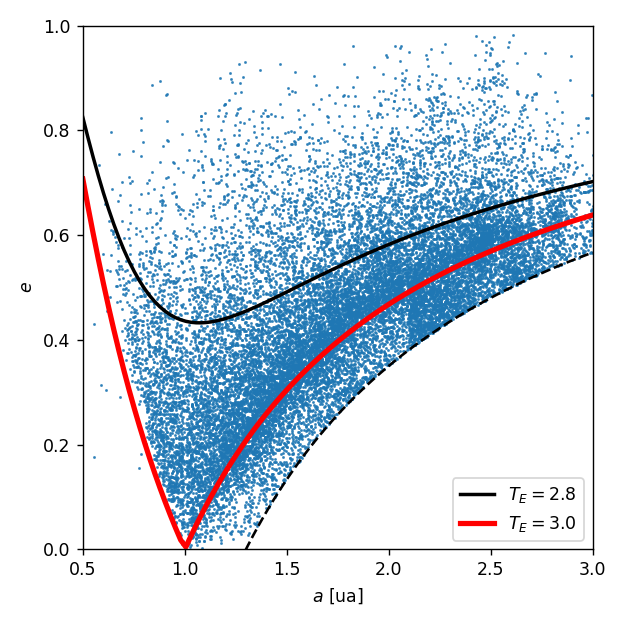

In [21]:
fig=plt.figure(figsize=(5,5))

#Dispersión de puntos
ax=fig.gca()
cond=datos["T"]>0.5
s=ax.scatter(datos[cond]["a"],datos[cond]["e"],
             s=0.5,alpha=0.8)

#Límite de la dispersión por definición de NEOs
from numpy import linspace,sqrt
aes=linspace(0.5,3.0,100)
eLs=1-1.3/aes
ax.plot(aes,eLs,'k--')

#Objetos con igual valor de T
T=2.8
eTs=sqrt(1-1/(4*aes**3)*(T*aes-1)**2)
ax.plot(aes,eTs,'k-',lw=2,label=f"$T_E={T}$")
T=3.0
eTs=sqrt(1-1/(4*aes**3)*(T*aes-1)**2)
ax.plot(aes,eTs,'r-',lw=3,label=f"$T_E={T}$")

#Decoración
ax.set_xlim((0.5,3.0))
ax.set_ylim((0.0,1.0))
ax.set_xlabel("$a$ [ua]")
ax.set_ylabel("$e$")
ax.legend()
fig.tight_layout()

<a id='code:NEOs_dispersion_limites'></a><center><b>Figura 8.142.</b> </center>

Nótese como el límite izquierdo de la distribución de NEOs en la Figura ([code:NEOs_dispersion_limites](#fig:code:NEOs_dispersion_limites)) esta determinado por aquellos cuerpos que tienen $T_E\leq 3$; es decir, el parámetro de Tisserand puede usarse como criterio numérico para determinar el valor mínimo de la excentricidad de un NEOs que tenga $a<1$.  

El gráfico de curvas con igual valor del parámetro de Tisserand muestra que la concentración que habíamos notado antes, corresponde a cuerpos con valor del parámetro de Tisserand entre $T_E=2.8$ y $T_E=3$.  Este último límite es muy importante a la hora de clasificar los NEOs en tres "familias" reconocidas:

- **Apollos**. Todos los NEOs tal que $T_E\le 3$ y $a\ge 1$.
- **Atens**. Todos los NEOs tal que $T_E\ge 3$ y $a\ge 1$.
- **Amors**. Todos los NEOs tal que $a\le 1$.


### 8.13.11. Clasificación de los objetos cercanos a Júpiter
<a id='T_jupiter_clasificacion'></a>

Podemos repetir un análisis similar en el caso de cuerpos pequeños cuyas órbitas son perturbadas por Júpiter.  Un caso particular de gran interés y muy conocido en estudios del sistema solar, es el de los denominados **cometas de la familia de Júpiter**.  

Con el algoritmo a continuación se leen los elementos órbitales de estos cuerpos y se grafican en el plano $a-e$.  Además incluímos la curva de igual valor del parámetro de Tisserand $T_J=3$:

<a id='code:T_cometas_jupiter'></a>

<IPython.core.display.Javascript object>


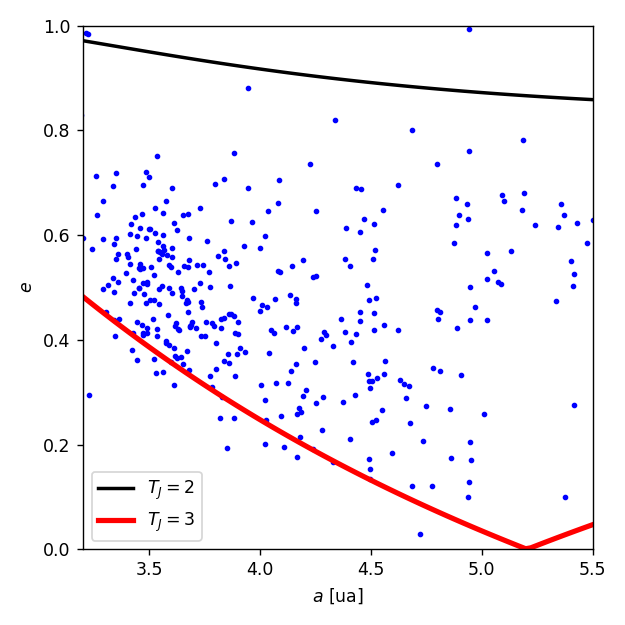

In [22]:
#Lee objetos
from pandas import read_csv
datos=read_csv("pymcel/data/JupiterComet-2020_02.csv",
               index_col=["full_name"])
datos["a"]=datos["q"]/(1-datos["e"])

#Gráfico de dispersión
fig=plt.figure(figsize=(5,5))
ax=fig.gca()
s=ax.scatter(datos["a"],datos["e"],
             s=5,c='b')

#Contorno de paraámetro de Tisserand
aJ=5.2044
from numpy import linspace,sqrt
aes=linspace(3.2,5.5,100)
T=2
eTs=sqrt(1-1/(4*(aes/aJ)**3)*(T*(aes/aJ)-1)**2)
ax.plot(aes,eTs,'k-',lw=2,label=f"$T_J={T}$")
T=3
eTs=sqrt(1-1/(4*(aes/aJ)**3)*(T*(aes/aJ)-1)**2)
ax.plot(aes,eTs,'r-',lw=3,label=f"$T_J={T}$")

#Decoración
ax.set_xlim((3.2,5.5))
ax.set_ylim((0.0,1.0))
ax.set_xlabel("$a$ [ua]")
ax.set_ylabel("$e$")
ax.legend(loc='lower left')
fig.tight_layout()

<a id='code:T_cometas_jupiter'></a><center><b>Figura 8.143.</b> </center>

Como puede notarse en el algoritmo, el cálculo del parámetro de Tisserand para el caso de Júpiter es necesario convertir el valor del semieje mayor que esta en unidades astronómicas, a las unidades canónicas del CRTBP del sistema Sol-Júpiter.  Esto implica, simplemente, reemplazar en la Ec. ([T_uc](#mjx-eqn-eq%3AT_uc)), $a$ por $a/a_p$ donde $a_p=5.2044$ es el semieje mayor de Júpiter.  Este sencillo cambio de unidades puede expresarse modificando la fórmula del parámetro de Tisserand para escribirla de la forma:

\begin{equation}
\label{eq:T_jupiter_uc}
T_p= \frac{a_p}{a}+2\cos i\sqrt{\frac{a}{a_p}(1-e^2)}
\end{equation}

Como puede verse en la Figura ([code:T_cometas_jupiter](#fig:code:T_cometas_jupiter)) los cometas de la familia de Júpiter con aquellos para los cuáles $2\leq T_J\leq 3$.  En contraste, los asteroides del cinturón principal (que no aparecen en la figura pero que tienen típicamente $a<3.5$ y órbitas con excentricidades $e<0.6$), tendrán $T_J>3$

[Indice](index.ipynb) | Previo: [Problema3Cuerpos.Aplicaciones.OrbitasCRTBP](08.06.02.00.Problema3Cuerpos.Aplicaciones.OrbitasCRTBP.ipynb) | Siguiente: [Problema3Cuerpos.ProblemasSeleccionados](08.06.00.00.Problema3Cuerpos.ProblemasSeleccionados.ipynb)